In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [10]:
  def make_hsi(image):
        h = np.zeros((image.shape[0], image.shape[1]), dtype = float)
        s = np.zeros((image.shape[0], image.shape[1]), dtype = float)
        i = np.zeros((image.shape[0], image.shape[1]), dtype = float)
      
        Rn = image[:, :, 0] / 255.0
        Gn = image[:, :, 1] / 255.0
        Bn = image[:, :, 2] / 255.0

        for r in range(image.shape[0]):
            for c in range(image.shape[1]):
                # Intensity
                i[r][c] = (Rn[r][c] + Gn[r][c] + Bn[r][c]) / 3
                
                # Saturation
                if (i[r][c] == 0): i[r][c] += 0.0001
                s[r][c] = 1 - (np.min([Rn[r][c], Gn[r][c], Bn[r][c]]) / i[r][c])

                # Hue
                temp = (2 * np.sqrt((Rn[r][c] - Gn[r][c]) ** 2 + (Rn[r][c] - Bn[r][c]) * (Gn[r][c] - Bn[r][c])))
                if (temp == 0): temp += 0.0001
                angle = (2 * Rn[r][c] - Gn[r][c] - Bn[r][c]) / temp
                angle = np.clip(angle, -1, 1)   
                h[r][c] = np.arccos(angle) / (2 * np.pi)
                if Bn[r][c] > Gn[r][c]:
                    h[r][c] = 1 - h[r][c]

        h = np.clip(h, 0, 1)
        s = np.clip(s, 0, 1)
        i = np.clip(i, 0, 1)

        return np.stack([h, s, i], axis=-1)

In [11]:
def hsi_to_rgb(image):
        newR = np.zeros((image.shape[0], image.shape[1]), dtype=float)
        newG = np.zeros((image.shape[0], image.shape[1]), dtype=float)
        newB = np.zeros((image.shape[0], image.shape[1]), dtype=float)
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                H = image[i][j][0] * 2 * np.pi  
                S = image[i][j][1]
                I = image[i][j][2]
                
                # 0 <= H < 2π/3
                if 0 <= H < 2 * np.pi/3:
                    newB[i][j] = I * (1 - S)
                    temp = np.cos(np.pi/3 - H)
                    if temp == 0: temp += 0.0001
                    newR[i][j] = I * (1 + (S * np.cos(H)) / temp)
                    newG[i][j] = 3 * I - (newR[i][j] + newB[i][j])
                
                # 2π/3 <= H < 4π/3
                elif 2 * np.pi/3 <= H < 4 * np.pi/3:
                    H = H - 2 * np.pi/3
                    newR[i][j] = I * (1 - S)
                    temp = np.cos(np.pi/3 - H)
                    if temp == 0: temp += 0.0001
                    newG[i][j] = I * (1 + (S * np.cos(H)) / temp)
                    newB[i][j] = 3 * I - (newR[i][j] + newG[i][j])
                
                # 4π/3 <= H < 2π
                elif 4 * np.pi/3 <= H < 2 * np.pi:
                    H = H - 4 * np.pi/3
                    newG[i][j] = I * (1 - S)
                    temp = np.cos(np.pi/3 - H)
                    if temp == 0: temp += 0.0001
                    newB[i][j] = I * (1 + (S * np.cos(H)) / temp)
                    newR[i][j] = 3 * I - (newG[i][j] + newB[i][j])

        newR = (np.clip(newR, 0, 1) * 255).astype(np.uint8)
        newG = (np.clip(newG, 0, 1) * 255).astype(np.uint8)
        newB = (np.clip(newB, 0, 1) * 255).astype(np.uint8)

        return np.stack([newR, newG, newB], axis=-1)

In [12]:
def contrast_stretching (a, b, alpha, beta, gamma, image):
    hsi_image = make_hsi(image)

    # 0 ~ 1 사이 값으로 처리함으로 a, b로 0 ~ 1 사이가 되도록 만듦
    a = a / 255.0
    b = b / 255.0
    
    for i in range (hsi_image.shape[0]):
        for j in range (hsi_image.shape[1]):
            if (0 <= image[i][j][2] < a):
                hsi_image[i][j][2] = hsi_image[i][j][2] * alpha
            elif(a <= image[i][j][2] < b):
                hsi_image[i][j][2] = (hsi_image[i][j][2] - a) * beta + a * alpha
            elif (b <= image[i][j][2] <= 255):
                hsi_image[i][j][2] = (hsi_image[i][j][2] - b) * gamma + (b - a) * beta + a * alpha
    np.clip(hsi_image[2], 0, 255)
    return hsi_to_rgb(hsi_image)

In [8]:
def gamma_correction(c, gamma, image):
    # 제곱을 정수형으로 계산하면 꺠짐
    image = image.astype(np.float32) / 255.0
    image = np.clip(c * np.power(image, gamma), 0, 1)
    return (image * 255).astype(np.uint8) 

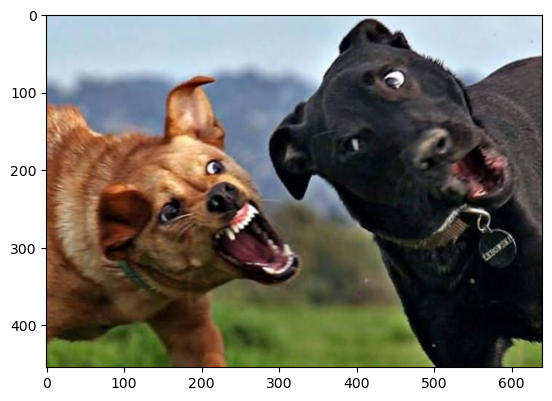

In [5]:
raw_image = cv2.imread('image.jpg')
image = cv2.cvtColor(raw_image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

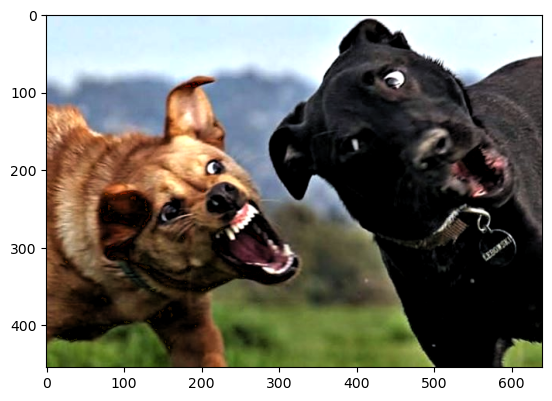

In [16]:
contrast_stretched_image = contrast_stretching(50, 150, 1.3, 1, 1.3, image)
plt.imshow(contrast_stretched_image)

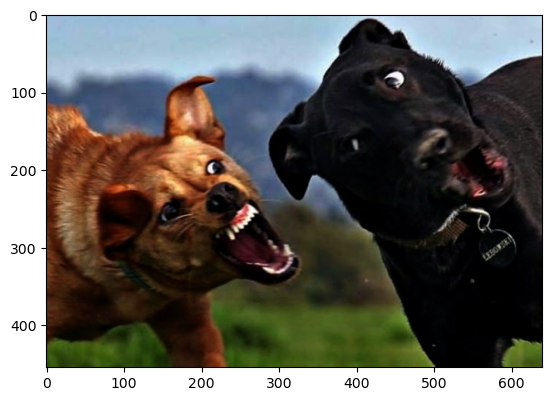

In [9]:
gamma_correction_image = gamma_correction(1, 1.5, image)
plt.imshow(gamma_correction_image)